In [40]:
import yfinance as yf

In [41]:
btc_ticker = yf.Ticker("BTC-USD")

In [42]:
btc = btc_ticker.history(period="max")

In [43]:
btc

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0
...,...,...,...,...,...,...,...
2022-08-27,20262.480469,20340.775391,19890.523438,20041.738281,30116729776,0,0
2022-08-28,20041.035156,20139.054688,19616.814453,19616.814453,24366810591,0,0
2022-08-29,19615.154297,20357.462891,19600.785156,20297.994141,32637854078,0,0


In [44]:
import pandas as pd

btc.index = pd.to_datetime(btc.index)

In [45]:
del btc["Dividends"]
del btc["Stock Splits"]

In [46]:
btc.columns = [c.lower() for c in btc.columns]

<AxesSubplot:xlabel='Date'>

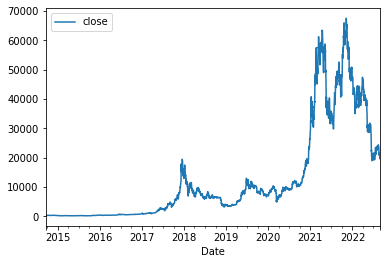

In [47]:
btc.plot.line(y="close", use_index=True)

In [48]:
btc["tomorrow"] = btc["close"].shift(-1)

In [49]:
btc["target"] = (btc["tomorrow"] > btc["close"]).astype(int)

In [50]:
wiki = pd.read_csv("wikipedia_edits.csv", index_col=0, parse_dates=True)

In [51]:
wiki

,edit_count,editor_count,ratio,difference,total_difference
2009-03-14,0.571429,0.285714,1.889466e+01,19.857143,79.428571
2009-03-15,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2009-03-16,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2009-03-17,0.000000,0.000000,0.000000e+00,0.000000,0.000000
2009-03-18,0.000000,0.000000,0.000000e+00,0.000000,0.000000
...,...,...,...,...,...
2022-08-27,0.285714,0.285714,1.851988e-09,0.000000,0.000000
2022-08-28,0.285714,0.285714,1.851988e-09,0.000000,0.000000
2022-08-29,0.571429,0.428571,7.602596e-05,17.000000,34.000000
2022-08-30,0.285714,0.142857,7.602411e-05,17.000000,34.000000


In [52]:
btc = btc.merge(wiki, left_index=True, right_index=True)

In [53]:
btc["target"].value_counts()

1    1559
0    1347
Name: target, dtype: int64

In [74]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = btc.iloc[:-200]
test = btc.iloc[-200:]

predictors = ["close", "volume", "open", "high", "low", "edit_count", "ratio", "difference"]
model.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [75]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["target"], preds)

0.4692737430167598

In [86]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

In [91]:
def backtest(data, model, predictors, start=1095, step=150):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [92]:
predictions = backtest(btc, model, predictors)

In [93]:
predictions["predictions"].value_counts()

1    1087
0     724
Name: predictions, dtype: int64

In [94]:
precision_score(predictions["target"], predictions["predictions"])

0.5243790248390064